In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os
import numpy as np
from collections import namedtuple
import cv2
from pathlib import Path
import argparse
import os
import csv
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense



# pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [2]:
### 실행결과 동일하게(완전 일치하지는 않음)
tf.keras.utils.set_random_seed(42)
### 텐서 연산 고정(완전 일치하지는 않음)
tf.config.experimental.enable_op_determinism()

In [3]:
folder_path_3 = "./data/이상(전도)"
folder_path_4 = "./data/이상(흡연)"

In [4]:
def concat(path):
    file_lst = os.listdir(path)
    df_list = []
    for file in file_lst:
        file_name = os.path.join(path, file)
        df = pd.read_csv(file_name)
        df = df[df.NUMOFBODIES != 0].reset_index(drop=True)
###
        if len(df) < 610:
            pad_length = 610 - len(df)
            pad_df = pd.DataFrame(0, index=range(len(df), 610), columns=df.columns)
            df = pd.concat([df, pad_df])
        df['index_num'] = df.index
###
        df_list.append(df)
    #concat_df = pd.concat(df_list, ignore_index=True)
    return df_list

In [5]:
smoke_mer = concat(folder_path_4)
jeon_mer = concat(folder_path_3)

In [6]:
jeon_mer = pd.concat(jeon_mer, ignore_index=True)
smoke_mer = pd.concat(smoke_mer, ignore_index=True)

In [7]:
jeon_mer['LABEL'] = 0
smoke_mer['LABEL'] = 1 

In [8]:
mer_lst = [
            jeon_mer,
            smoke_mer]
full_data = pd.concat(mer_lst, ignore_index=True)
full_data.shape

(34160, 42)

In [9]:
full_data = full_data.drop(full_data.columns[1:14], axis=1)
full_data

,NUMOFBODIES,LEFT_SHOULDER_X,LEFT_SHOULDER_Y,RIGHT_SHOULDER_X,RIGHT_SHOULDER_Y,LEFT_ELBOW_X,LEFT_ELBOW_Y,RIGHT_ELBOW_X,RIGHT_ELBOW_Y,LEFT_WRIST_X,...,RIGHT_KNEE_X,RIGHT_KNEE_Y,LEFT_ANKLE_X,LEFT_ANKLE_Y,RIGHT_ANKLE_X,RIGHT_ANKLE_Y,HEAD_X,HEAD_Y,index_num,LABEL
0,1,1816.0,46.0,1815.0,40.0,1828.0,83.0,1764.0,87.0,1854.0,...,1763.0,151.0,1803.0,183.0,1761.0,167.0,1819.2,30.4,0,0
1,1,1096.0,166.0,1091.0,163.0,1087.0,232.0,1079.0,220.0,1066.0,...,1048.0,331.0,1037.0,399.0,1032.0,399.0,1083.8,129.4,1,0
2,1,1069.0,167.0,1039.0,166.0,1060.0,223.0,1028.0,220.0,1053.0,...,1027.0,329.0,1043.0,403.0,1022.0,403.0,1049.2,131.8,2,0
3,1,1031.0,179.0,981.0,182.0,1058.0,227.0,981.0,238.0,1048.0,...,1000.0,347.0,1018.0,411.0,995.0,418.0,1004.0,145.8,3,0
4,1,999.0,202.0,949.0,196.0,1007.0,258.0,952.0,256.0,1005.0,...,945.0,365.0,975.0,437.0,956.0,435.0,969.4,160.2,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34155,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,605,1
34156,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,606,1
34157,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,607,1
34158,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,608,1


In [10]:
data_without_label = full_data.drop(['LABEL'], axis=1)
label_data = full_data['LABEL']

In [11]:
data_without_label.shape

(34160, 28)

In [12]:
sequence_start_indices = full_data.index[full_data['index_num'] == 0].tolist()
sequence_lengths = [sequence_start_indices[i] - sequence_start_indices[i-1] for i in range(1, len(sequence_start_indices))]
sequence_lengths.insert(0, sequence_start_indices[0])

# Min sequence length
min_sequence_length = min(sequence_lengths)

In [13]:
min_sequence_length = 610

In [14]:
X_sequences = []
y_sequences = []

# Iterating over the start indices to create sequences
for i in range(len(sequence_start_indices) - 1):
    start_index = sequence_start_indices[i]
    end_index = sequence_start_indices[i + 1]

    # Ensure the sequence has the expected length before appending
    if end_index - start_index == min_sequence_length:
        X_sequence = data_without_label.iloc[start_index:end_index].values
        y_sequence = label_data.iloc[start_index:end_index].values
        X_sequences.append(X_sequence)
        y_sequences.append(y_sequence[-1])  # Taking the label of the last frame for the sequence

# Converting lists to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

X_sequences.shape, y_sequences.shape


((55, 610, 28), (55,))

In [15]:
# 모델 불러오기
from keras.models import load_model
model1 = load_model('./model/smoke (2).h5')

In [16]:
X_sequences, y_sequences
X_val = X_sequences.astype(np.float32)
y_val = y_sequences.astype(np.float32)

In [17]:
# 테스트 데이터에 대한 예측을 한 번만 수행
test_preds = model1.predict(X_val)
test_pred_idx = [np.argmax(pred) for pred in test_preds]

In [18]:
test_pred_idx

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

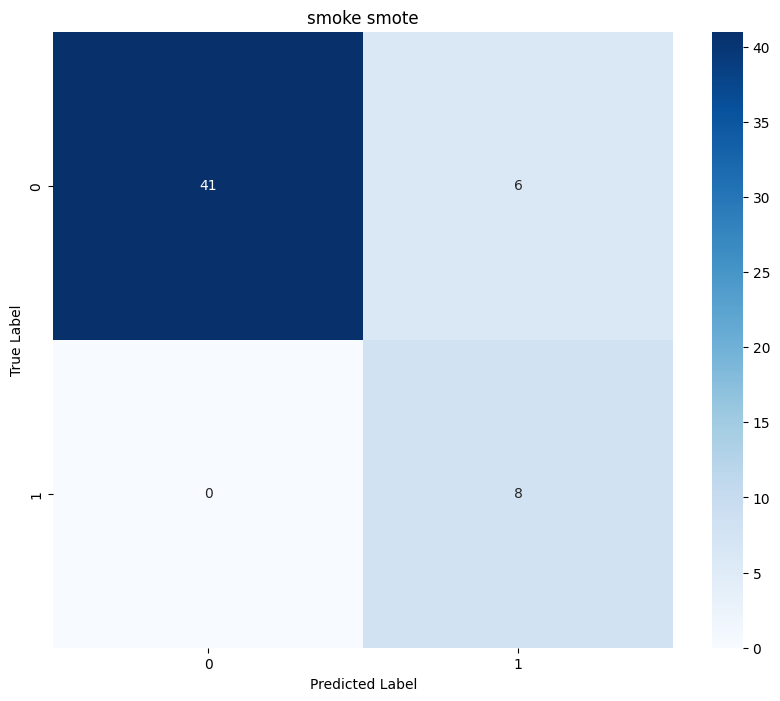

F1 Score: 0.9020661157024794

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.87      0.93        47
         1.0       0.57      1.00      0.73         8

    accuracy                           0.89        55
   macro avg       0.79      0.94      0.83        55
weighted avg       0.94      0.89      0.90        55



In [19]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 실제 레이블과 예측 레이블을 사용하여 Confusion Matrix를 계산합니다.
conf_matrix = confusion_matrix(y_val, test_pred_idx)

# F1 Score를 계산합니다.
f1 = f1_score(y_val, test_pred_idx, average='weighted')

# Confusion Matrix를 시각화합니다.
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# 모델에 맞게 타이틀 변경하기
plt.title('smoke smote')
plt.show()

# 결과를 출력합니다.
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_val, test_pred_idx))

In [21]:
X_sequences

array([[[1.0000e+00, 1.8160e+03, 4.6000e+01, ..., 1.8192e+03,
         3.0400e+01, 0.0000e+00],
        [1.0000e+00, 1.0960e+03, 1.6600e+02, ..., 1.0838e+03,
         1.2940e+02, 1.0000e+00],
        [1.0000e+00, 1.0690e+03, 1.6700e+02, ..., 1.0492e+03,
         1.3180e+02, 2.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00,
         0.0000e+00, 6.0700e+02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00,
         0.0000e+00, 6.0800e+02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00,
         0.0000e+00, 6.0900e+02]],

       [[1.0000e+00, 5.4200e+02, 6.4000e+01, ..., 5.3920e+02,
         5.7800e+01, 0.0000e+00],
        [1.0000e+00, 5.4200e+02, 6.4000e+01, ..., 5.4080e+02,
         5.8600e+01, 1.0000e+00],
        [1.0000e+00, 5.3000e+02, 6.7000e+01, ..., 5.4000e+02,
         6.0600e+01, 2.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00,
         0.0000e+00, 6.0700e+02],
        [0.0

In [32]:
X_sequences

array([[[1.0000e+00, 1.8160e+03, 4.6000e+01, ..., 1.8192e+03,
         3.0400e+01, 0.0000e+00],
        [1.0000e+00, 1.0960e+03, 1.6600e+02, ..., 1.0838e+03,
         1.2940e+02, 1.0000e+00],
        [1.0000e+00, 1.0690e+03, 1.6700e+02, ..., 1.0492e+03,
         1.3180e+02, 2.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00,
         0.0000e+00, 6.0700e+02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00,
         0.0000e+00, 6.0800e+02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00,
         0.0000e+00, 6.0900e+02]],

       [[1.0000e+00, 5.4200e+02, 6.4000e+01, ..., 5.3920e+02,
         5.7800e+01, 0.0000e+00],
        [1.0000e+00, 5.4200e+02, 6.4000e+01, ..., 5.4080e+02,
         5.8600e+01, 1.0000e+00],
        [1.0000e+00, 5.3000e+02, 6.7000e+01, ..., 5.4000e+02,
         6.0600e+01, 2.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00,
         0.0000e+00, 6.0700e+02],
        [0.0

In [34]:
for i, slice_ in enumerate(X_sequences):
    np.savetxt(f"./my_data_slice_{i}.csv", slice_, delimiter=",")


In [ ]:
for i, slice_ in enumerate(X_val):
    np.savetxt(f"./my_data_slice_{i}.csv", slice_, delimiter=",")